# Data Scientist Assessment Test

The next notebook will present the Data Scientist Assessment test for the Melonn Company.

In this, we'll have to predict the monthly sales of a company in order to help them to efficiently contract the required personal

Presented by: Yorley Palacios

In [379]:
#importing libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import floor

In [2]:
#reading data
df = pd.read_csv('Datos_Prueba_DataScientist.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153275 entries, 0 to 153274
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   OrderId         153275 non-null  object
 1   RequestTime     153275 non-null  object
 2   DeliveryOption  153275 non-null  object
dtypes: object(3)
memory usage: 3.5+ MB


In [4]:
df.RequestTime = pd.to_datetime(df.RequestTime, format='%Y%m%d %H:%M:%S', errors='raise')

In [5]:
df.head(10)

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm
5,PED_6,2018-01-01 10:21:53,Mismo dia entre 6:30 pm y 8:30 pm
6,PED_7,2018-01-01 10:27:17,Mismo dia entre 6:30 pm y 8:30 pm
7,PED_8,2018-01-01 10:48:53,Mismo dia entre 6:30 pm y 8:30 pm
8,PED_9,2018-01-01 11:13:10,Mismo dia entre 6:30 pm y 8:30 pm
9,PED_10,2018-01-01 11:39:26,Siguiente dia entre las 6:30 pm y 8:30 pm


let's check if is there any additional DeliveryOption due to typos.

In [6]:
df.DeliveryOption.unique()

array(['Mismo dia entre 6:30 pm y 8:30 pm',
       'Siguiente dia entre 12:30 pm y 2:30 pm',
       'Siguiente dia entre las 6:30 pm y 8:30 pm'], dtype=object)

We have no problem with this feature, so we can proceed to determine the Delivery Day of each order according to the  criteria defined by ABC

In [7]:
df['Delivery_Day'] = [x if y == 'Mismo dia entre 6:30 pm y 8:30 pm'  else x + timedelta(days=1) for (x,y) in zip(df.RequestTime,df.DeliveryOption)]

In [8]:
df['Delivery_Day'] = df.Delivery_Day.dt.date

In [9]:
df.head()

,OrderId,RequestTime,DeliveryOption,Delivery_Day
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,2018-01-02
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,2018-01-02


ABC has explicitly defined shift criteria for the delivery options 1 and 3, and since the vehicles for the delivery of the option 2 orders leave at 12 PM, this order should be enlisted in the morning shift

In [ ]:
df['enlisted_shift'] = ['Afternoon' if x == 'Mismo dia entre 6:30 pm y 8:30 pm' else 'Morning' for x in df.DeliveryOption]

In [11]:
df.head()

,OrderId,RequestTime,DeliveryOption,Delivery_Day,enlisted_shift
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01,Afternoon
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01,Afternoon
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,2018-01-01,Afternoon
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,2018-01-02,Morning
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,2018-01-02,Morning


With this process ready, now we can make a daily aggregation of all the orders.

In [21]:
table = pd.pivot_table(df, values='OrderId', index=['Delivery_Day'],
                    columns=['enlisted_shift'], aggfunc=np.count_nonzero)
table.fillna(0, inplace = True)
table

In [23]:
table['Total'] = table['Afternoon'] + table['Morning']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5469364A8>,
      dtype=object)

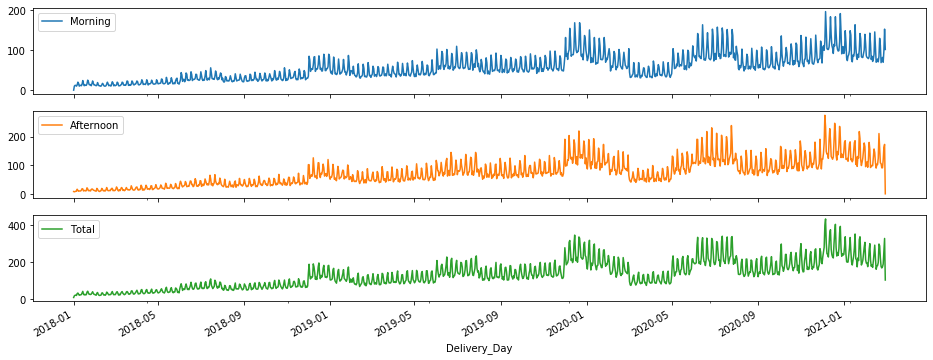

In [43]:
#visualize the behavior of the orders through time
table[['Morning','Afternoon','Total']].plot(figsize= (16,6), subplots = True)

We can see that that the orders shows an increasing trend and a seasonality with variable period. These traits will be helpful since they indicate that this features have a high autocorrelation coefficient, but just to be sure, let's make an autocorrelation plot.

In [414]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

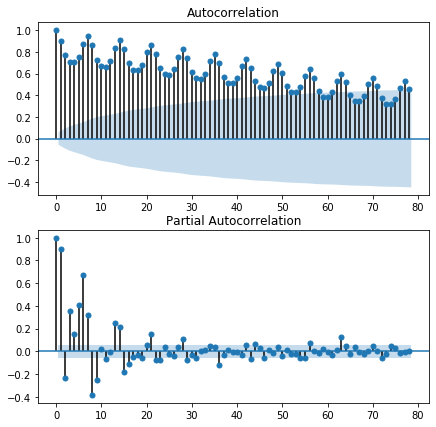

In [416]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(7,7))
plot_acf(table['Total'], lags=78, alpha = 0.05, ax = ax1)
plot_pacf(table['Total'], lags=78, alpha = 0.05, ax= ax2)
fig.patch.set_facecolor('xkcd:white')
plt.show()

As guessed before with the previous illustration, the series has a high autocorrelation with the previous value (t - 1), and with other superiors orders also indicating seasonal effects (e.g. t -8, t-14, t -22, etc.). If we were to realize an pure statistical prediction we would need to make sure of transform the data to make the serie stationary (the mean and variance of the serie do not change with time) but we are not going to take that path.

In [386]:
#lets analize the historic distribution of the orders per shift
table['Morning_%'] = table['Morning'] / table['Total']

In [47]:
table['Afternoon_%'] = table['Afternoon'] / table['Total']

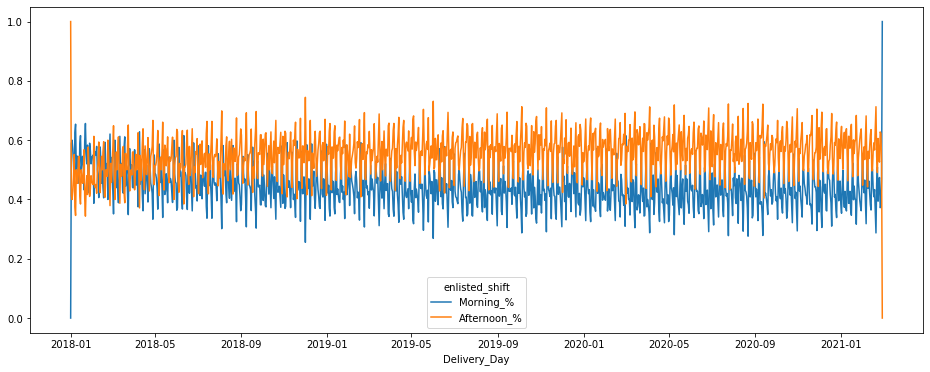

In [50]:
table[['Morning_%', 'Afternoon_%']].plot(figsize= (16,6))

In [402]:
shifts = table[['Morning_%', 'Afternoon_%']].mean()
shifts

Morning_%      0.444131
Afternoon_%    0.555869
dtype: float64

This analysis shows that the afternoon shift has a bigger load of work than the morning one, having the latter on average 44% of all the orders.

In [26]:
#adding year and month as a feature for the analysis
table['year'] = table.index.values
table['year'] = pd.to_datetime(table.year, format='%Y-%m-%d', errors='raise')
table['year'] = table.year.dt.year
                                
table['month'] = table.index.values
table['month'] = pd.to_datetime(table.month, format='%Y-%m-%d', errors='raise')
table['month'] = table.month.dt.month

In [27]:
table

enlisted_shift,Afternoon,Morning,Total,Op_shift2,Op_shift1,Op_Total,year,month
Delivery_Day,,,,,,,,
2018-01-01,8.0,0.0,8.0,1,0,1,2018,1
2018-01-02,7.0,10.0,17.0,1,2,3,2018,1
2018-01-03,8.0,12.0,20.0,1,2,4,2018,1
2018-01-04,9.0,12.0,21.0,1,2,4,2018,1
2018-01-05,9.0,10.0,19.0,1,2,3,2018,1
...,...,...,...,...,...,...,...,...
2021-02-25,91.0,82.0,173.0,18,16,34,2021,2
2021-02-26,118.0,70.0,188.0,23,14,37,2021,2
2021-02-27,162.0,98.0,260.0,32,19,52,2021,2


### Affectedness level by COVID-19

In [60]:
## building data of affectednessof sales by COVID-19
# for the month prior to COVID-19 the impact is zero
impact = {'2020-03-01':3,'2020-04-01':3,'2020-05-01':1,'2020-06-01':1,
'2020-07-01':1,'2020-08-01':2,'2020-09-01':2,'2020-10-01':1,
'2020-11-01':1,'2020-12-01':2,'2021-01-01':2,'2021-02-01':1}
impact = pd.DataFrame(impact.items(), columns=['date', 'affectednes'])
impact.date = pd.to_datetime(impact.date, format='%Y-%m-%d', errors='raise')
impact['year'] = impact.date.dt.year
impact['month'] = impact.date.dt.month
impact

,date,affectednes,year,month
0,2020-03-01,3,2020,3
1,2020-04-01,3,2020,4
2,2020-05-01,1,2020,5
3,2020-06-01,1,2020,6
4,2020-07-01,1,2020,7
5,2020-08-01,2,2020,8
6,2020-09-01,2,2020,9
7,2020-10-01,1,2020,10
8,2020-11-01,1,2020,11
9,2020-12-01,2,2020,12


In [68]:
# adding level of affectedness of sales by COVID-19 as a feature

table = table.merge(impact[['affectednes','year','month']], how='left', on=['year','month'])
table.affectednes.fillna(0, inplace= True)
table.shape

,Afternoon,Morning,Total,Op_shift2,Op_shift1,Op_Total,year,month,Morning_%,Afternoon_%,affectednes
0,8.0,0.0,8.0,1,0,1,2018,1,0.000000,1.000000,0.0
1,7.0,10.0,17.0,1,2,3,2018,1,0.588235,0.411765,0.0
2,8.0,12.0,20.0,1,2,4,2018,1,0.600000,0.400000,0.0
3,9.0,12.0,21.0,1,2,4,2018,1,0.571429,0.428571,0.0
4,9.0,10.0,19.0,1,2,3,2018,1,0.526316,0.473684,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1151,91.0,82.0,173.0,18,16,34,2021,2,0.473988,0.526012,1.0
1152,118.0,70.0,188.0,23,14,37,2021,2,0.372340,0.627660,1.0
1153,162.0,98.0,260.0,32,19,52,2021,2,0.376923,0.623077,1.0
1154,173.0,153.0,326.0,34,30,65,2021,2,0.469325,0.530675,1.0


## Predicting Sales with Linear Regression

Given the behavior shown by the data and the size of the dataset we consider that a Linear Regression Model will have an adecuate perfomance for the required task

### Feature to Predict
we are not using the mean of the series as the final feature to predict but the mean plus 2 times the stardard deviation, this is in order to increase the coverage of the many days with higher demand.

In [380]:
# building final Dataset for Prediction
data = table.groupby(['year', 'month']).agg({'Total': ['mean', 'std']})
data.reset_index(level=['year', 'month'], inplace= True)
data.columns = ['year', 'month', 'mean', 'std']
data = data.merge(impact[['affectednes','year','month']], how='left', on=['year','month'])
data.affectednes.fillna(0, inplace= True)
data['estimated_sales'] = data['mean'] + data['std'] * 2
data.drop(['mean', 'std'], axis=1, inplace = True)
data.fillna(0, inplace=True)
data.head()

,year,month,affectednes,estimated_sales
0,2018,1,0.0,40.881951
1,2018,2,0.0,38.169228
2,2018,3,0.0,44.484341
3,2018,4,0.0,54.038810
4,2018,5,0.0,61.845634


Since we saw a high autocorrelation in the data of sales in previous analysis, adding as a feature the sales of the last month will help us not to lose this information in the training process.

In [362]:
data['last_month_sales'] = data['estimated_sales'].diff()
data['last_month_sales'] = data['estimated_sales'] - data['last_month_sales']
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True,inplace=True)
data.shape

,year,month,affectednes,estimated_sales,last_month_sales
0,2018,2,0.0,38.169228,40.881951
1,2018,3,0.0,44.484341,38.169228
2,2018,4,0.0,54.038810,44.484341
3,2018,5,0.0,61.845634,54.038810
4,2018,6,0.0,87.563301,61.845634


In [198]:
# importing Libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder

In [226]:
# defining custom function to estimate some regression metrics on the model
def custom_metrics(true, pred):
    df = pd.DataFrame(true)
    df.reset_index(inplace=True, drop=True)
    df.columns = ['true']
    n=df.shape[0]
    mean = df.true.mean()

    df['pred'] = pred
    #1
    df['abs_error'] = np.abs(df.true-df.pred)
    df['p_abs_error'] = df['abs_error']/df.true
    #2
    df['sqrt_error'] = np.power(df.true-df.pred,2)
    #3
    df['sqrt_std_error'] = np.power(df.true-mean,2)
    #4
    df['pred_sqrt_diff'] = np.power(df.pred.diff(),2)
    #5
    df['CID'] = df.true.diff() * df.pred.diff()
    df['CID'] = [1 if x>0 else 0 for x in df.CID ]
    #7
    df['IA'] = np.power(df['abs_error'] + np.abs(df.true-mean),2)

    MAE = df['abs_error'].sum()/n
    MAPE = df['p_abs_error'].sum()/n
    RMSE = np.sqrt(df['sqrt_error'].sum()/n)
    R2 = 1 - df.sqrt_error.sum()/df.sqrt_std_error.sum()
    theil_u = df.sqrt_error.iloc[1:].sum()/df.pred_sqrt_diff.iloc[1:].sum()
    POCID = 100 * df.CID.sum()/n
    ARV = (df.sqrt_error.sum()/df.sqrt_std_error.sum())/n
    IA = df.sqrt_error.sum()/df.IA.sum()

    indicators= {'MAE': MAE, 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2, 'theil_u':theil_u, 'POCID': POCID, 'ARV': ARV, 'IA':IA }
    ind = pd.DataFrame(indicators.values(), index= indicators.keys())
    ind.columns = ['Metrics']
    return ind

In [363]:
# getting apart the period to predict (March-2021)
validation = data[(data.iloc[:,0] == 2021) &  (data.iloc[:,1] == 3)].copy()
validation.reset_index(inplace= True, drop = True)
validation = validation.drop('estimated_sales' ,axis=1)
validation

,year,month,affectednes,last_month_sales
0,2021,3,0.0,311.317074


In [364]:
#getting dummies for the categorical variables in the data
enc_a = OneHotEncoder(handle_unknown='ignore')
enc_a = OneHotEncoder(sparse=False)

enc_y = OneHotEncoder(handle_unknown='ignore')
enc_y = OneHotEncoder(sparse=False)

enc_m = OneHotEncoder(handle_unknown='ignore')
enc_m = OneHotEncoder(sparse=False)

In [365]:
dummies_a = pd.DataFrame(enc_a.fit_transform(np.array(data.affectednes).reshape(-1, 1)))
dummies_y = pd.DataFrame(enc_y.fit_transform(np.array(data.year).reshape(-1, 1)))
dummies_m = pd.DataFrame(enc_m.fit_transform(np.array(data.month).reshape(-1, 1)))

In [366]:
data = pd.concat([data,dummies_y], axis =1)
data = pd.concat([data,dummies_m], axis =1)
data = pd.concat([data,dummies_a], axis =1)
data.shape

(38, 25)

In [367]:
#data without the period to predict
data = data[~((data.iloc[:,0] == 2021) & (data.iloc[:,1] == 3))].copy()
data.drop(['year','month', 'affectednes'], axis =1, inplace =True)

In [368]:
y = data.pop('estimated_sales')
X = data

### Training Model

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [396]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 13)
scores = cross_val_score(regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
-scores

array([48.49642534, 26.98302425,  4.45555369, 27.80389815, 50.11127865,
       18.62358928, 57.31076337, 24.51824738, 63.47340787, 56.16022835])

In [397]:
# mean score of cross_validation
-scores.mean()

37.793641631710486

In [398]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [372]:
#sorted(sklearn.metrics.SCORERS.keys())

In [399]:
custom_metrics(y_test, y_pred)

,Metrics
MAE,34.246964
MAPE,0.185082
RMSE,49.553954
R2,0.801539
theil_u,0.084830
POCID,83.333333
ARV,0.016538
IA,0.119558


We can a see a good perfomance in all the metrics defined. 

The error obtain with the RMSE is a little higher than the average of the cross validation, however it's still in an acceptable range.


The R2 Coeffient indicated that the model can explained almost 80% of the variance of the model with the features used.

The POCID indicates how well the model respond to the changes of directions of the series, and although 83% is a pretty high value, since the data used for the training was shuffle the use of this metrics is not reliable.

### Predicting sales for March 2021

In [375]:
#getting dummies for the categorical variables
dummies_a = pd.DataFrame(enc_a.transform(np.array(validation.affectednes).reshape(-1, 1)))
dummies_y = pd.DataFrame(enc_y.transform(np.array(validation.year).reshape(-1, 1)))
dummies_m = pd.DataFrame(enc_m.transform(np.array(validation.month).reshape(-1, 1)))
val_data = pd.concat([validation['last_month_sales'],dummies_y,dummies_m, dummies_a], axis=1, ignore_index= True)

In [401]:
#predicting value
sales_march = regressor.predict(val_data)
sales_march

array([218.54868861])

The Predicted value by the model is 218.
Using the represetation of order per shift estimated ealier in this notebook, we can calculate the number of orders of each shift.

In [404]:
morning_shift = sales_march * shifts[0]
afternoon_shift = sales_march - morning_shift

[218.54868861]


In [405]:
morning_shift

array([97.06434881])

In [406]:
afternoon_shift

array([121.4843398])

Now let's convert the orders per shift to required staff using the minimum work ratio per operator.
the minimum work ratio of orders picked per hour is 5, and since each shift is 6 hour long, we have a minumum of 30 orders per shift picked by operator.

In [408]:
pickers_morning = floor(morning_shift/30)
pickers_morning

3

In [410]:
pickers_afternoon = floor(afternoon_shift/30)
pickers_afternoon

4

## Conclusions!

According to the analysis carried out in this notebook, the recommendation for the ABC company in order to satisfy the fulfillment of all the orders in an efficient way is to hire for the month of March: 3 operators for the morning shift and 4 for the afternoon shift.